In [8]:
! pip install -r requirements.txt --quiet

In [6]:
from dotenv import load_dotenv
from os import environ
from langchain_openai import AzureChatOpenAI
from typing_extensions import TypedDict,Literal
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from  user_tools import get_weather_tool
from user_functions import vector_search  
from utils import pretty_print_messages
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent

load_dotenv(override=True)



members = ["document_search", "weather"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = AzureChatOpenAI(
        temperature=0,
        azure_deployment=environ["AZURE_OPENAI_MODEL"],
        api_version=environ["AZURE_OPENAI_API_VERSION"]
    )


llm_with_tools = create_react_agent(llm, tools=[get_weather_tool])



In [7]:
def document_search(state: MessagesState) -> Command[Literal["supervisor"]]:
    messages = state["messages"]
    last_user_message = next((msg for msg in reversed(messages)), None)
    if not last_user_message:
        return Command(goto="supervisor")

    query = last_user_message.content
    context = vector_search(query)  

    
    messages.append(
    SystemMessage(
        content=(
            f"You are a helpful assistant. Use only the information in the context below to answer the user's question. "
            f"If the context does not contain the answer, respond with \"I don't know.\"\n\nContext:\n{context}"
        )
    )
)

    response = llm.invoke(messages)

    return Command(
        update={
            "messages": [
                HumanMessage(content=response.content, name="document_search")
            ]
        },
        goto="supervisor",
    )


def weather(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = llm_with_tools.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="weather")
            ]
        },
        goto="supervisor",
    )

def supervisor(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [8]:

builder = StateGraph(MessagesState)
builder.add_node("document_search", document_search)
builder.add_node("weather", weather)
builder.add_node("supervisor", supervisor)

builder.set_entry_point("supervisor")

graph = builder.compile()


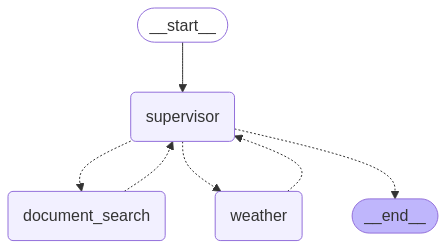

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
for step in graph.stream({"messages": [{"role": "user", "content": "Describe the resource intensity of data center facility infrastructure"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node document_search:


================================ Human Message =================================
Name: document_search

The resource intensity of data center facility infrastructure is described using two key metrics: **Power Usage Effectiveness (PUE)** and **Water Usage Effectiveness (WUE)**. 

- **PUE** is defined as the total electricity demand of the data center divided by the electricity demand of the IT equipment. It is dimensionless (kWh/kWh) and reflects the efficiency of the facility's energy use.
- **WUE** is defined as the total water consumption of the data center divided by the electricity demand of the IT equipment, reported in liters per kWh. It primarily accounts for on-site water consumption associated with cooling infrastructure.

These metrics are influenced by factors such as cooling systems, operational practices, and climatic conditions. Additionally, indirect resource impacts, such as water consumption and gree

In [11]:
for step in graph.stream({"messages": [{"role": "user", "content": "what is the weather in sf"}]}):
   pretty_print_messages(step)

Update from node supervisor:




Update from node weather:


================================ Human Message =================================
Name: weather

The weather in San Francisco is currently 60°F and foggy.


Update from node supervisor:




